In [47]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Define functions

def identify_missing_regions(damaged_image):
    """
    Identify missing regions in the damaged image.

    Parameters:
    damaged_image (np.ndarray): The input damaged image (grayscale or color).

    Returns:
    labeled_image (np.ndarray): Labeled image.
    regions (list): List of region properties.
    binary_image (np.ndarray): Binary image with isolated damaged regions.
    """
    if len(damaged_image.shape) == 3 and damaged_image.shape[2] == 3:
        # Convert the image to grayscale if it is in color
        gray_image = cv2.cvtColor(damaged_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = damaged_image
    
    # Use a fixed threshold to isolate the damaged region (black line)
    _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Perform morphological operations to clean up the binary image
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.erode(binary_image, kernel, iterations=1)
    binary_image = cv2.dilate(binary_image, kernel, iterations=2)
    
    # Label connected components
    labeled_image = measure.label(binary_image, connectivity=2)
    regions = measure.regionprops(labeled_image)
    
    return labeled_image, regions, binary_image

def sort_regions_by_area(regions):
    sorted_regions = sorted(regions, key=lambda region: region.area, reverse=True)
    return sorted_regions

def check_if_empty(L):
    if not L:
        print("List L is empty. The inpainting process is complete.")
        return True
    else:
        print("List L is not empty. Proceeding to the next steps.")
        return False

def select_and_dilate_smallest_region(L, original_image, dilation_size=10, dilation_iterations=2):
    if not L:
        raise ValueError("List L is empty. Cannot select and dilate the smallest region.")
    
    smallest_region = L[-1]
    
    mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    for coord in smallest_region.coords:
        mask[coord[0], coord[1]] = 255
    
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return mask, dilated_mask

def crop_corresponding_area(dilated_mask, original_image):
    coords = cv2.findNonZero(dilated_mask)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_area = original_image[y:y+h, x:x+w]
    return cropped_area, (x, y, w, h)

def compute_smoothing_parameter(cropped_image):
    I_x = cv2.Sobel(cropped_image, cv2.CV_64F, 1, 0, ksize=1)
    I_y = cv2.Sobel(cropped_image, cv2.CV_64F, 0, 1, ksize=1)
    G = np.sqrt(I_x**2 + I_y**2)
    rho = np.max(G)
    sigma = np.exp(1 - (rho / 255))
    return sigma, I_x, I_y

def dilated_mask_crop(cropped_image):
    if len(cropped_image.shape) == 3:
        _, dilated_mask = cv2.threshold(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY), 10, 255, cv2.THRESH_BINARY_INV)
    else:
        _, dilated_mask = cv2.threshold(cropped_image, 10, 255, cv2.THRESH_BINARY_INV)
    return dilated_mask

def create_training_data_from_cropped(cropped_image, dilated_mask, neighbor_radius=10):
    assert cropped_image.shape[:2] == dilated_mask.shape, "Dimensions of cropped image and mask must match."
    
    inpainting_region = dilated_mask.astype(bool)
    
    neighbor_mask = cv2.dilate(inpainting_region.astype(np.uint8), 
                               np.ones((2 * neighbor_radius + 1, 2 * neighbor_radius + 1), np.uint8), 
                               iterations=1) & ~inpainting_region

    coords = np.column_stack(np.where(neighbor_mask))
    
    if len(cropped_image.shape) == 3:  # Color image
        pixel_values = cropped_image[coords[:, 0], coords[:, 1], :]
    else:  # Grayscale image
        pixel_values = cropped_image[coords[:, 0], coords[:, 1]].reshape(-1, 1)
    
    return coords, pixel_values

class OptimizedGRNN:
    def __init__(self, sigma=None):
        self.sigma = sigma
        self.training_set = None
        self.target_values = None

    def fit(self, features, targets):
        self.training_set = features
        self.target_values = targets

    def predict(self, features, batch_size=1000):
        predictions = []
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_features = features[start:end]
            
            distance_matrix = cdist(batch_features, self.training_set, 'sqeuclidean')
            kernel_matrix = np.exp(-distance_matrix / (2 * self.sigma ** 2))
            if len(self.target_values.shape) == 2 and self.target_values.shape[1] == 3:
                batch_predictions = np.dot(kernel_matrix, self.target_values) / kernel_matrix.sum(axis=1, keepdims=True)
            else:
                batch_predictions = np.dot(kernel_matrix, self.target_values) / kernel_matrix.sum(axis=1)
            
            predictions.append(batch_predictions)
        
        return np.concatenate(predictions, axis=0)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [48]:
def apply_text_mask_to_image(image_path, mask_path, output_image_path, text_color=(0, 0, 255)):
    """
    Apply a text mask to a color image, overlaying the text.
    
    Parameters:
    image_path (str): Path to the input color image.
    mask_path (str): Path to the mask image.
    output_image_path (str): Path to save the output masked image.
    text_color (tuple): Color of the text in BGR format.
    
    Returns:
    None
    """
    # Load the color image
    image = cv2.imread(image_path)
    
    # Load the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Ensure the mask and image have the same dimensions
    if image.shape[:2] != mask.shape[:2]:
        raise ValueError("The mask and image must have the same dimensions.")
    
        # Create an inverse mask
    inverse_mask = cv2.bitwise_not(mask)
    
    # Convert the inverse mask to a 3-channel image
    inverse_mask_3_channel = cv2.cvtColor(inverse_mask, cv2.COLOR_GRAY2BGR)
    
    # Apply the inverse mask to the image
    masked_image = cv2.bitwise_and(image, inverse_mask_3_channel)
    
    # Save the resulting image
    cv2.imwrite(output_image_path, masked_image)

image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testdata\Lenna_color.png"
mask_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\text_mask.jpg"
output_image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\masked_image.jpg"
apply_text_mask_to_image(image_path, mask_path, output_image_path)

In [49]:
import random
def create_multiple_holes(image_path, output_path, num_holes=5, max_hole_size=50):
    """
    Create multiple holes on a color image.

    Parameters:
    image_path (str): Path to the input color image.
    output_path (str): Path to save the output image with holes.
    num_holes (int): Number of holes to create on the image.
    max_hole_size (int): Maximum size of the holes.

    Returns:
    None
    """
    # Load the color image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    height, width, _ = image.shape
    
    for _ in range(num_holes):
        # Randomly choose the center and size of the hole
        center_x = random.randint(0, width)
        center_y = random.randint(0, height)
        hole_size = random.randint(10, max_hole_size)
        
        # Draw a circle (hole) on the image
        cv2.circle(image, (center_x, center_y), hole_size, (0, 0, 0), -1)
    
    # Save the resulting image
    cv2.imwrite(output_path, image)

# Example usage:
create_multiple_holes(
    image_path=r"C:\Users\VIET HOANG - VTS\Desktop\testdata\Lenna_color.png",
    output_path=r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\image_with_holes.jpg",
    num_holes=30,
    max_hole_size=15
)

In [ ]:


# Main inpainting loop
damaged_image_multiple_rectangles = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\image_with_holes.jpg")

while True:
    labeled_image, regions, binary_image = identify_missing_regions(damaged_image_multiple_rectangles)
    
    # Sort regions by area in descending order and store them in a list tagged as L
    L = sort_regions_by_area(regions)
    if not check_if_empty(L):
        # Select and dilate the smallest region
        mask, dilated_mask = select_and_dilate_smallest_region(L, damaged_image_multiple_rectangles)
        # Crop the corresponding area from the original image
        cropped_area, bbox = crop_corresponding_area(dilated_mask, damaged_image_multiple_rectangles)
        
        # Compute the smoothing parameter
        sigma, I_x, I_y = compute_smoothing_parameter(cropped_area)
        dilated_mask = dilated_mask_crop(cropped_area)
        # Create training data from the cropped area
        X_train, y_train = create_training_data_from_cropped(cropped_area, dilated_mask)
        
        # Fit the GRNN model
        grnn_model = OptimizedGRNN(sigma=5)
        grnn_model.fit(X_train, y_train.reshape(-1, y_train.shape[-1]))
        
        # Inpaint the damaged region
        inpainted_area = cropped_area.copy()
        damaged_coords = np.column_stack(np.where(dilated_mask))
        
        predicted_values = grnn_model.predict(damaged_coords)

        if len(cropped_area.shape) == 3:
            inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1], :] = predicted_values.astype(np.uint8)
        else:
            inpainted_area[damaged_coords[:, 0], damaged_coords[:, 1]] = predicted_values.astype(np.uint8).flatten()
        
        # Restore the inpainted area back to the original image
        x, y, w, h = bbox
        restored_image = damaged_image_multiple_rectangles.copy()
        restored_image[y:y+h, x:x+w] = inpainted_area
        
        # Save the restored image
        cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\restored_img.jpg', restored_image)

        # Sharpen the restored image
        sharpened_image = sharpen_image(restored_image)

        # Display the original, inpainted, and sharpened images
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.title('Before')
        plt.imshow(cv2.cvtColor(damaged_image_multiple_rectangles, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('After')
        plt.imshow(cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Sharpened')
        plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.show()
        
        # Update the damaged image for the next iteration
        damaged_image_multiple_rectangles = restored_image
    else:
        break


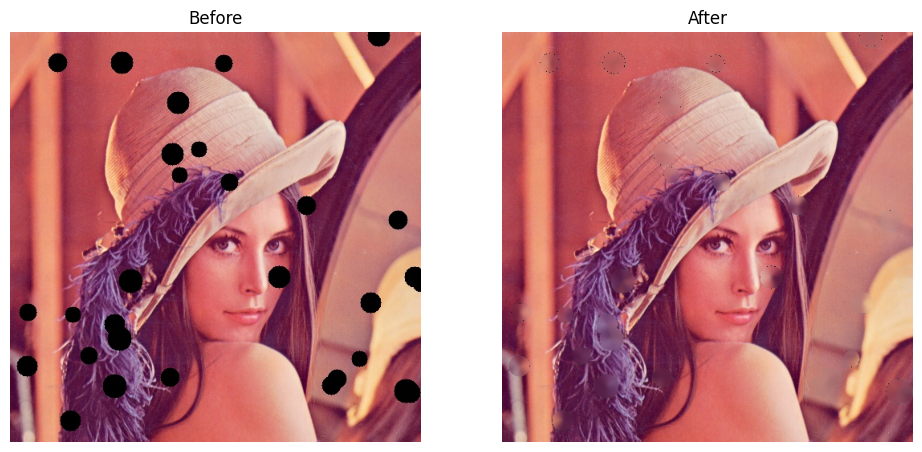

In [51]:
import cv2
import matplotlib.pyplot as plt

# Step 2: Read the image with holes
image_with_holes = cv2.imread(r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\image_with_holes.jpg")

# Step 3: Convert the image from BGR to RGB
image_with_holes_rgb = cv2.cvtColor(image_with_holes, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 6))
# Step 4: Display the 'Before' image
plt.subplot(1, 3, 1)
plt.title('Before')
plt.imshow(image_with_holes_rgb)
plt.axis('off')

# Assuming 'restored_image' is already processed and available
# Step 6: Convert the restored image from BGR to RGB (if necessary)
restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB)

# Step 7: Display the 'After' image
plt.subplot(1, 3, 2)
plt.title('After')
plt.imshow(restored_image_rgb)
plt.axis('off')

plt.show()

